In [14]:
# Here are the default libraries imported from Kaggle to let us work on the dataset in the tab "Input."
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1180_virus_2010.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1676_virus_2892.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1230_virus_2081.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1513_virus_2632.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person124_virus_238.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person746_virus_1369.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person588_bacteria_2422.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person466_virus_960.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset/PNEUMONIA/person1590_bacteria_4175.jpeg
/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Datas

# Model Preprocessing

In [15]:
#Importing some more libraries
!pip install tqdm 

import shutil 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

print("Libraries imported successfully")

Libraries imported successfully


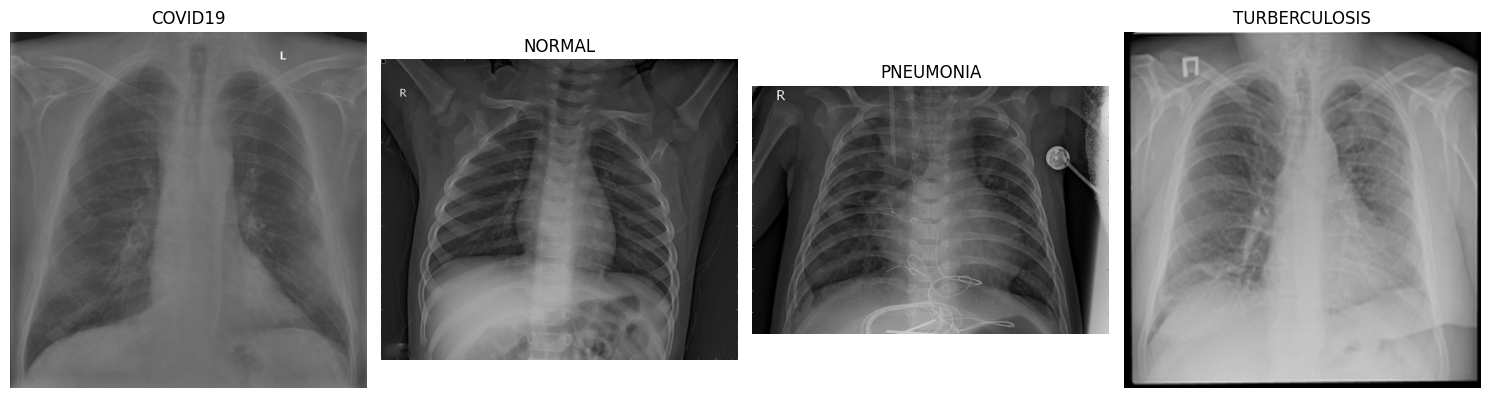

In [16]:
'''
Reorganizing the dataset into an array of image_path and label to split the images for training and testing.
The result should be a simple table with two columns (image path, label)
At the end, I print the first 5 rows to confirm the data.
I display a sample of X-Ray for each category.
'''

# Define base path
base_path = '/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset'

# Reorganize the dataset
data = []
for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            if os.path.isfile(file_path):
                data.append({'image_path': file_path, 'label': label})

# Create a DataFrame
df = pd.DataFrame(data)



# Select one sample per category
unique_labels = df['label'].unique()
sample_images = df.groupby('label').first().reset_index()

# Plot one image per category
plt.figure(figsize=(15, 10))
for i, row in sample_images.iterrows():
    image_path = row['image_path']
    label = row['label']
    image = mpimg.imread(image_path)
    
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
'''
Now we split the Dataframe into training data, validation data (used for the training process), and the testing data (to test our model).
We split first 70% of the data to the train dataset (train_df), and 30% to temporary dataset (temp_def, used for the test and validation).
Then, we split the temporary dataset in half for the test data (test_df) and validation data (val_df).
In the end, we have 70% training images (train_df), 15% validation images (val_df), and 15% testing images (test_df).
I print the amount of images for each category to confirm the sizes.
'''

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")


Training samples: 4992
Validation samples: 1070
Test samples: 1070


In [18]:
''' 
My dataset has much more data for pneumonia and normal X_ray samples. This is an issue in Machine Learning because the model will train
more often on these samples. Which will lead him to be less performant for the Covid and Tuberculosis samples. To solve this issue I use oversampling 
technique. I duplicate the Covid and Tuberculosis images for the model to see these images equally with other samples.
To do so I need to copy the image, assign a path name to the duplicate and save it in a dedicated file (oversampled_data).
At the end I print the number of images for each illness to confirm we balanced properly our data which is 3000 images for each illness.
Note that we do this only for the training data. 
'''

def oversample_training_set(df, target_count_per_class, output_dir):
    """
    Oversample the dataset to ensure balanced classes and save duplicate files in a writable directory.
    """
    oversampled_data = []

    for label in df['label'].unique():
        class_subset = df[df['label'] == label]
        oversample_count = target_count_per_class - len(class_subset)

        # Add original data
        oversampled_data.extend(class_subset.to_dict(orient='records'))

        # Create duplicates in the writable output directory
        if oversample_count > 0:
            label_dir = os.path.join(output_dir, label)
            os.makedirs(label_dir, exist_ok=True)  # Ensure directory exists
            
            for _, row in class_subset.sample(oversample_count, replace=True, random_state=42).iterrows():
                original_path = row['image_path']
                
                # Generate a unique name for the duplicate
                new_file_name = f"{os.path.splitext(os.path.basename(original_path))[0]}_dup_{len(oversampled_data)}{os.path.splitext(original_path)[1]}"
                new_file_path = os.path.join(label_dir, new_file_name)
                
                # Physically copy the file
                shutil.copy(original_path, new_file_path)
                
                # Add the duplicate to the DataFrame
                new_row = row.copy()
                new_row['image_path'] = new_file_path
                oversampled_data.append(new_row)

    return pd.DataFrame(oversampled_data)


# Define output directory for writable files
output_dir = '/kaggle/working/oversampled_data'

# Oversample training set
train_df_balanced = oversample_training_set(train_df, target_count_per_class=3000, output_dir=output_dir)

# Check the new training set distribution
print(train_df_balanced['label'].value_counts())

label
PNEUMONIA        3000
TURBERCULOSIS    3000
COVID19          3000
NORMAL           3000
Name: count, dtype: int64


In [19]:
'''
Now, it is time to organize my directory. I put my images in test, train and validation (val) folders.
The MobileNetV2 model is expecting the images to be organized this way.
'''

def organize_dataset_with_progress(df, base_output_path):
    """
    Organizes the dataset into directories for train, validation, and test,
    copying all files into the appropriate folders.
    """
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {base_output_path}"):
        label = row['label']
        src_path = row['image_path']  # Use the correct column
        dest_dir = os.path.join(base_output_path, label)
        os.makedirs(dest_dir, exist_ok=True)  # Ensure the directory exists
        dest_path = os.path.join(dest_dir, os.path.basename(src_path))
        
        try:
            shutil.copy(src_path, dest_path)  # Copy the file
        except Exception as e:
            print(f"Error copying {src_path} to {dest_path}: {e}")

# Define output paths
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Remove the train, val, and test folders completely
for folder in [train_path, val_path, test_path]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# Organize datasets with a progress bar
organize_dataset_with_progress(train_df_balanced, train_path)
organize_dataset_with_progress(val_df, val_path)
organize_dataset_with_progress(test_df, test_path)


Processing /kaggle/working/test: 100%|██████████| 1070/1070 [00:02<00:00, 480.70it/s]



Displaying samples from: /kaggle/working/train


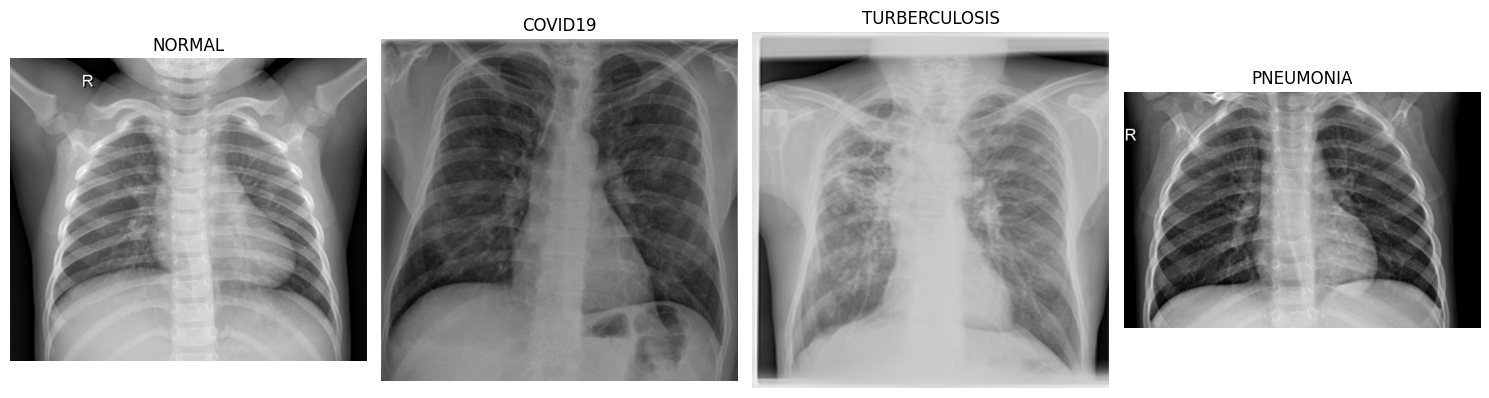


Displaying samples from: /kaggle/working/val


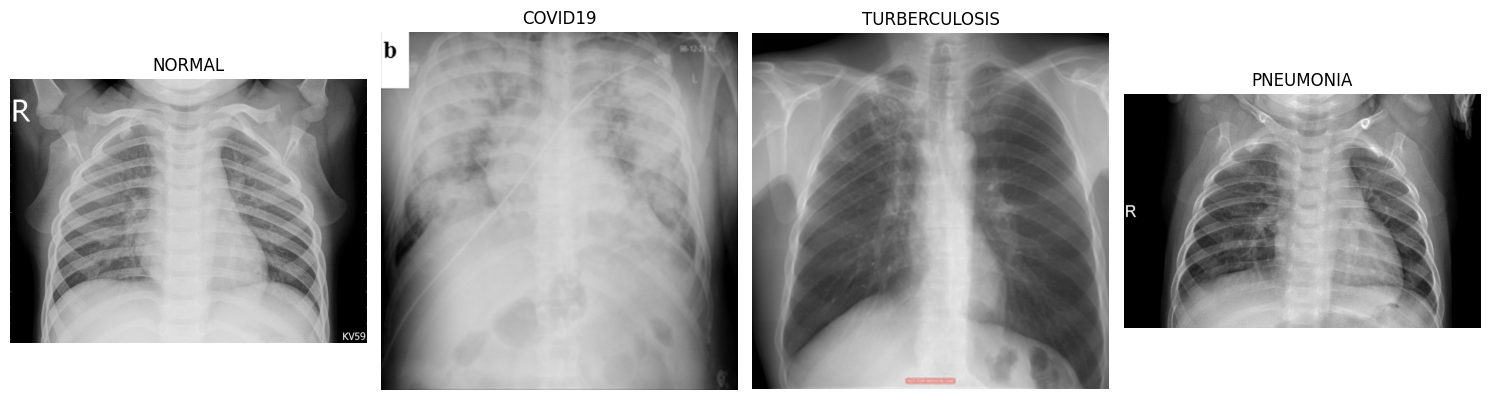


Displaying samples from: /kaggle/working/test


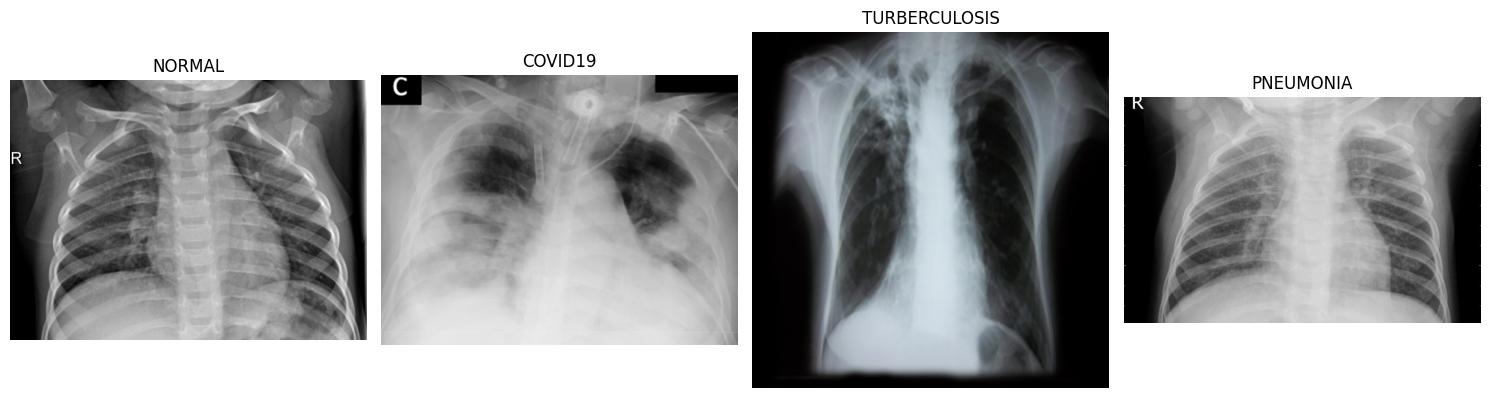

In [20]:
def display_samples_from_folders(base_paths):
    """
    Displays one sample image from each subfolder (label category) in the given base paths.
    """
    for base_path in base_paths:
        print(f"\nDisplaying samples from: {base_path}")
        categories = os.listdir(base_path)
        plt.figure(figsize=(15, 10))
        for i, category in enumerate(categories):
            category_path = os.path.join(base_path, category)
            if os.path.isdir(category_path):
                # Get the first image in the category
                first_image = os.listdir(category_path)[0]
                first_image_path = os.path.join(category_path, first_image)
                # Read and plot the image
                image = mpimg.imread(first_image_path)
                plt.subplot(1, len(categories), i + 1)
                plt.imshow(image, cmap='gray')
                plt.title(category)
                plt.axis('off')
        plt.tight_layout()
        plt.show()

# Define base paths
base_paths = [train_path, val_path, test_path]

# Display samples from train, val, and test folders
display_samples_from_folders(base_paths)


In [21]:
'''
I assign the folders path to their value to use them into the model.
I also create mulitple angles of the same image to increase the number of images for the model to train.
''' 


# Paths to the train, validation, and test directories
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Training data generator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=40,         # Random rotation
    width_shift_range=0.2,     # Random horizontal shift
    height_shift_range=0.2,    # Random vertical shift
    shear_range=0.2,           # Random shear transformation
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flip
    fill_mode='nearest'        # Fill missing pixels after transformations
)

# Validation and test data generators (no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1]
)


In [22]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Resize images to match input size of the model
    batch_size=32,           # Number of images per batch
    class_mode='categorical' # Multi-class classification
)

# Validation data generator
val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test data generator
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffling for test data to ensure reproducibility
)


Found 12000 images belonging to 4 classes.
Found 1070 images belonging to 4 classes.
Found 1070 images belonging to 4 classes.


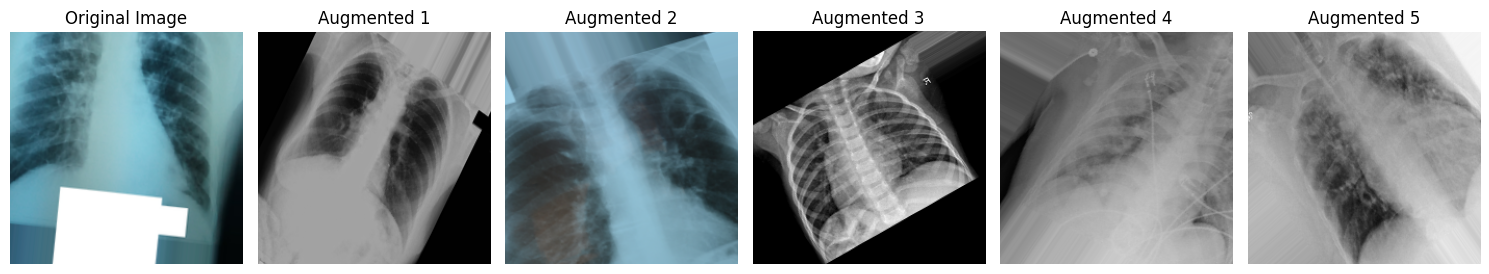

In [23]:


# Define a single image for augmentation
# Reset the generator to fetch images from the start
train_generator.reset()
original_images, labels = next(train_generator)  # Fetch a single batch
original_image = original_images[0]  # Take the first image in the batch

# Generate multiple augmented versions of the same image
augmented_images = []
for _ in range(5):  # Generate 5 augmented images
    augmented_image, _ = next(train_generator)
    augmented_images.append(augmented_image[0])  # Take the augmented version of the first image

# Plot the original image alongside the augmented images
plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, 6, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Plot augmented images
for i, aug_image in enumerate(augmented_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(aug_image)
    plt.title(f"Augmented {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Model Training

In [24]:
# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Learning rate scheduler to reduce learning rate on plateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))


# Unfreeze the last 50 layers
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.6)(x)              # Dropout for regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Fully connected layer with L2
predictions = Dense(4, activation='softmax')(x)  # Output layer (4 classes)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [lr_scheduler, early_stopping]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights, 
    callbacks=callbacks,
    verbose=1
)

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5: None -- [Errno -3] Temporary failure in name resolution

# Model Testing 

In [ ]:
# Ensure all test images are used
steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)

# Print the number of test images and steps
print(f"Total number of test images: {test_generator.samples}")
print(f"Number of steps used for evaluation: {steps}")
print(f"Batch size: {test_generator.batch_size}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=steps, verbose=1)

# Calculate error rate
error_rate = 1 - test_accuracy

# Print results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error Rate: {error_rate}")


In [ ]:
# Ensure all test images are used
steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)
images_used = steps * test_generator.batch_size
print(f"Number of images being used in this evaluation: {images_used}")

# Get predictions for all test images
predictions = model.predict(test_generator, steps=steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)


# Get true labels for the full test set
true_labels = test_generator.classes


# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=list(test_generator.class_indices.keys())))


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Fetch multiple batches to collect enough test data
all_images = []
all_true_labels = []

# Collect all images and labels from the generator
for i in range(len(test_generator)):
    images, true_labels = next(test_generator)
    all_images.append(images)
    all_true_labels.append(true_labels)

# Concatenate all batches into a single array
all_images = np.concatenate(all_images, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

# Predict labels for all test images
predictions = model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# Decode true labels from one-hot encoding
true_labels = np.argmax(all_true_labels, axis=1)

# Decode class indices
class_labels = list(test_generator.class_indices.keys())

# Select 15 random indices
random_indices = np.random.choice(len(all_images), size=15, replace=False)

# Plot random images with their predictions
plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)  # 3 rows and 5 columns
    plt.imshow(all_images[idx])
    true_label = class_labels[true_labels[idx]]
    predicted_label = class_labels[predicted_labels[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
